# **Dimensionality Reduction + Clustering**

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# Load Iris dataset
from sklearn.datasets import load_iris

# Load dataset
def load_and_prepare_data():
    iris = load_iris()
    data = pd.DataFrame(iris.data, columns=iris.feature_names)
    data['target'] = iris.target
    return data

# Call the function
data = load_and_prepare_data()
print(data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [72]:
def preprocess_data(data):
    # Separate features and labels
    features = data.drop(columns=['target'])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return scaled_features

# Preprocess the data
scaled_data = preprocess_data(data)


In [73]:
def tune_tsne_and_dbscan(
        scaled_data,
        perplexities=[5, 30, 50],
        iterations=[500, 5000],
        eps_values=[0.3, 0.5, 0.7],
        min_samples_values=[3, 5]
):
    best_score = -1
    best_params = None
    results = []

    for p in perplexities:
        for it in iterations:
            # Apply t-SNE with the current perplexity & iteration settings
            tsne = TSNE(n_components=2, perplexity=p, max_iter=it, random_state=42)
            tsne_data = tsne.fit_transform(scaled_data)

            for eps in eps_values:
                for ms in min_samples_values:
                    # Apply DBSCAN on the t-SNE output
                    dbscan = DBSCAN(eps=eps, min_samples=ms)
                    labels = dbscan.fit_predict(tsne_data)

                    # Only compute Silhouette if there's more than one cluster
                    # and not *everything* is labeled as outlier (-1)
                    unique_labels = set(labels)
                    if len(unique_labels) > 1 and -1 in unique_labels and len(unique_labels) > 2:
                        # If you want to include outliers in your measurement
                        # or exclude them, that’s up to your analysis needs.
                        pass
                    if len(unique_labels) > 1:
                        score = silhouette_score(tsne_data, labels)
                        results.append((p, it, eps, ms, score))

                        # Track if this is the best so far
                        if score > best_score:
                            best_score = score
                            best_params = (p, it, eps, ms)

    return best_score, best_params, results


best_score, best_params, all_results = tune_tsne_and_dbscan(scaled_data)

print("Best Silhouette Score:", best_score)
print("Best Parameter Combination (perplexity, n_iter, eps, min_samples):", best_params)
print("All results:", all_results)

Best Silhouette Score: 0.516712
Best Parameter Combination (perplexity, n_iter, eps, min_samples): (50, 500, 0.7, 5)
All results: [(30, 500, 0.3, 3, np.float32(-0.6148905)), (30, 500, 0.5, 3, np.float32(-0.15154557)), (30, 500, 0.7, 3, np.float32(0.2573757)), (30, 500, 0.7, 5, np.float32(-0.084771715)), (30, 5000, 0.3, 3, np.float32(-0.6942631)), (30, 5000, 0.5, 3, np.float32(-0.1709123)), (30, 5000, 0.7, 3, np.float32(0.22573853)), (30, 5000, 0.7, 5, np.float32(-0.18630986)), (50, 500, 0.3, 3, np.float32(0.042621624)), (50, 500, 0.3, 5, np.float32(-0.38714668)), (50, 500, 0.5, 3, np.float32(0.41374344)), (50, 500, 0.5, 5, np.float32(0.37778878)), (50, 500, 0.7, 3, np.float32(0.29348937)), (50, 500, 0.7, 5, np.float32(0.516712)), (50, 5000, 0.3, 3, np.float32(0.079922795)), (50, 5000, 0.3, 5, np.float32(-0.38511556)), (50, 5000, 0.5, 3, np.float32(0.41349116)), (50, 5000, 0.5, 5, np.float32(0.37163952)), (50, 5000, 0.7, 3, np.float32(0.293151)), (50, 5000, 0.7, 5, np.float32(0.51567143

In [74]:
def apply_dimensionality_reduction(scaled_data, method='PCA', n_components=2, **kwargs):
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components, **kwargs)
    else:
        raise ValueError("Method must be 'PCA' or 't-SNE'")
    reduced_data = reducer.fit_transform(scaled_data)
    return reduced_data

# Apply the best t-SNE params from the tuner:
if best_params:
    p, it, eps, ms = best_params
    tsne_data_optimized = apply_dimensionality_reduction(
        scaled_data,
        method='t-SNE',
        n_components=2,
        perplexity=p,
        max_iter=it,
        random_state=42
    )
else:
    # If something went wrong or no best_params found, fallback
    tsne_data_optimized = apply_dimensionality_reduction(
        scaled_data,
        method='t-SNE',
        n_components=2,
        perplexity=30,
        max_iter=1000,
        random_state=42
    )


# Apply PCA
pca_data = apply_dimensionality_reduction(scaled_data, method='PCA')

In [75]:
def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

# Apply DBSCAN to raw and reduced data
dbscan_labels_raw = apply_dbscan(scaled_data)
dbscan_labels_pca = apply_dbscan(pca_data)
if best_params:
    p, it, eps, ms = best_params
    labels_optimized = apply_dbscan(tsne_data_optimized, eps=eps, min_samples=ms)
else:
    labels_optimized = apply_dbscan(tsne_data_optimized, eps=0.5, min_samples=5)


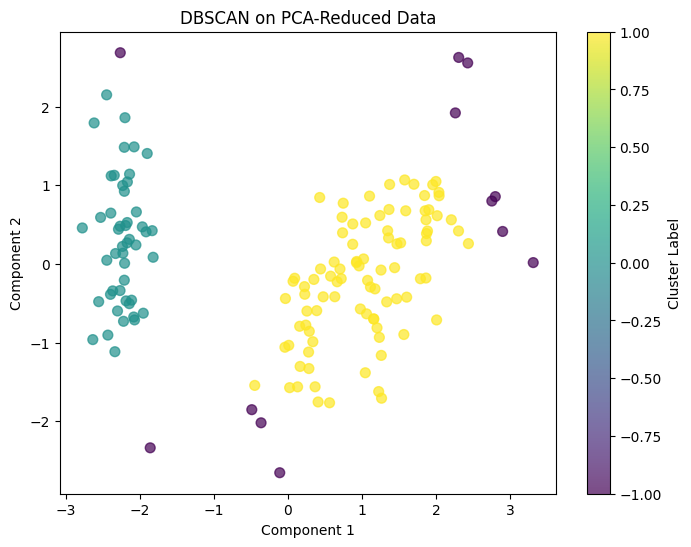

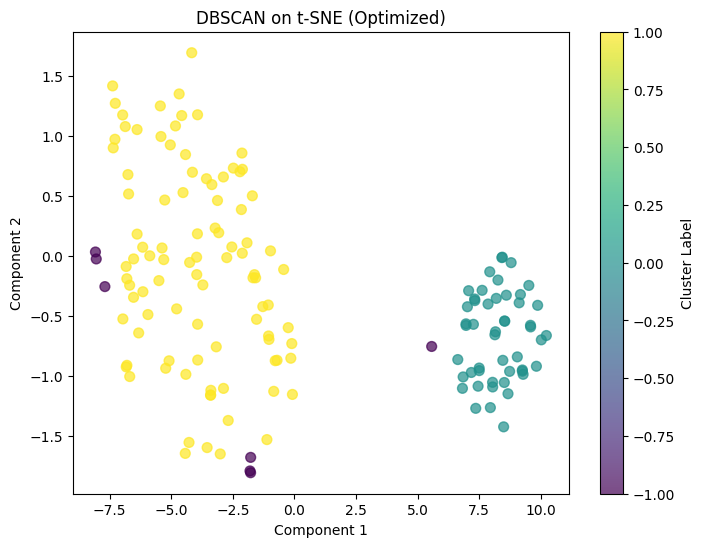

In [76]:
def plot_clustering_results(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Visualise results
plot_clustering_results(pca_data, dbscan_labels_pca, "DBSCAN on PCA-Reduced Data")
plot_clustering_results(tsne_data_optimized, labels_optimized, "DBSCAN on t-SNE (Optimized)")


In [77]:
from sklearn.metrics import silhouette_score

def evaluate_clustering(data, labels):
    if len(set(labels)) > 1:
        score = silhouette_score(data, labels)
        return score
    else:
        return "Silhouette Score not defined for single cluster"

# Evaluate clustering
raw_score = evaluate_clustering(scaled_data, dbscan_labels_raw)
pca_score = evaluate_clustering(pca_data, dbscan_labels_pca)
tsne_score_optimized = evaluate_clustering(tsne_data_optimized, labels_optimized)

print("Silhouette Scores:")
print(f"Raw Data: {raw_score}")
print(f"PCA-Reduced Data: {pca_score}")
print(f"t-SNE-Reduced Data: {tsne_score_optimized}")


Silhouette Scores:
Raw Data: 0.35651648142700726
PCA-Reduced Data: 0.524530747414399
t-SNE-Reduced Data: 0.5167120099067688
